In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df=pd.read_csv('Frozen_Dessert_Production.csv',
               parse_dates=True,index_col='DATE')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
IPN31152N    573 non-null float64
dtypes: float64(1)
memory usage: 9.0 KB


In [10]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [11]:
df.columns=['Production']

In [12]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


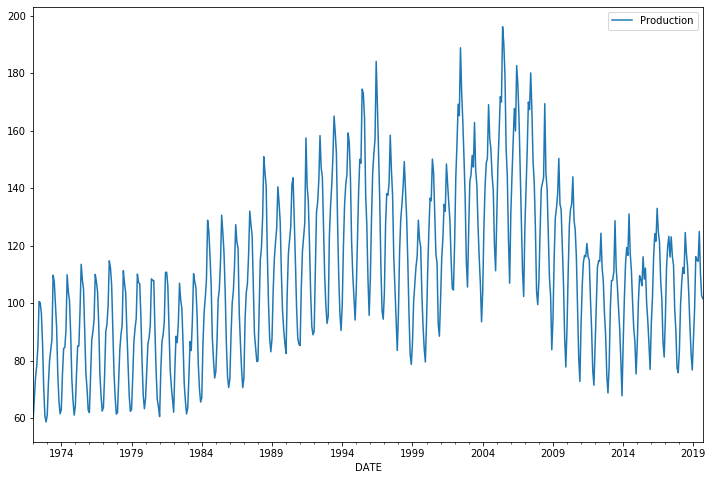

In [15]:
df.plot(figsize=(12,8))

In [16]:
len(df)

573

In [17]:
test_ind=len(df)-24

In [18]:
train=df.iloc[:test_ind]
test=df.iloc[test_ind:]

In [19]:
len(test)

24

In [20]:
len(train)

549

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler=MinMaxScaler()

In [23]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [24]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [25]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [26]:
length=18
generator=TimeseriesGenerator(scaled_train,scaled_train,
                             length=length,batch_size=1)

In [27]:
from tensorflow.keras.models import Sequential

In [28]:
from tensorflow.keras.layers import Dense,LSTM

In [29]:
n_features=1

In [32]:
model=Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [36]:
validation_generator=TimeseriesGenerator(scaled_test,scaled_test,
                                        length=length,batch_size=1)

In [37]:
model.fit_generator(generator,epochs=15,validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/15
531/531 [==============================] - 21s 40ms/step - loss: 0.0264 - val_loss: 0.0045
Epoch 2/15
531/531 [==============================] - 21s 39ms/step - loss: 0.0104 - val_loss: 0.0013
Epoch 3/15
531/531 [==============================] - 22s 41ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 4/15
531/531 [==============================] - 20s 38ms/step - loss: 0.0039 - val_loss: 0.0018


In [38]:
losses=pd.DataFrame(model.history.history)

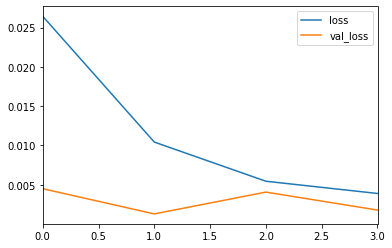

In [40]:
losses.plot()

In [42]:
test_predictions=[]

first_eval_batch=scaled_train[-length:]
current_batch=first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
     current_pred=model.predict(current_batch)[0]
     
     test_predictions.append(current_pred)
     
     current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [43]:
true_predictions=scaler.inverse_transform(test_predictions)

In [44]:
test['Predictions']=true_predictions

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


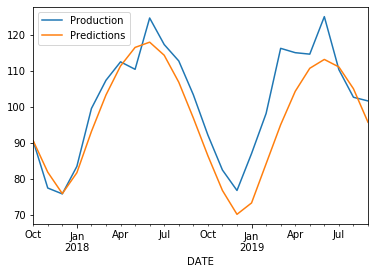

In [46]:
test.plot()

In [47]:
full_scaler=MinMaxScaler()
scaled_full_data=full_scaler.fit_transform(df)

In [48]:
length=12
generator=TimeseriesGenerator(scaled_full_data,scaled_full_data,
                             length=length,batch_size=1)

In [49]:
model=Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [50]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
561/561 [==============================] - 17s 30ms/step - loss: 0.0305
Epoch 2/5
561/561 [==============================] - 17s 30ms/step - loss: 0.0116
Epoch 3/5
561/561 [==============================] - 17s 30ms/step - loss: 0.0052
Epoch 4/5
561/561 [==============================] - 17s 30ms/step - loss: 0.0046
Epoch 5/5
561/561 [==============================] - 17s 31ms/step - loss: 0.0043


In [64]:
forecast=[]
period=24

first_eval_batch=scaled_test[-length:]
current_batch=first_eval_batch.reshape((1,length,n_features))

for i in range(period):
     current_pred=model.predict(current_batch)[0]
     
     forecast.append(current_pred)
     
     current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [65]:
forecast=scaler.inverse_transform(forecast)

In [66]:
forecast

array([[ 85.28749074],
       [ 78.56170134],
       [ 77.73502   ],
       [ 84.5472391 ],
       [ 93.49651899],
       [ 99.29354416],
       [103.14151091],
       [104.66959467],
       [105.97078793],
       [103.1171633 ],
       [ 95.09049415],
       [ 80.13381448],
       [ 68.89639448],
       [ 64.46286238],
       [ 63.76533995],
       [ 69.3794963 ],
       [ 77.30223015],
       [ 83.98716631],
       [ 89.3774254 ],
       [ 93.09844527],
       [ 92.39128277],
       [ 85.40803209],
       [ 73.21916003],
       [ 62.59003085]])

In [67]:
df.tail()

,Production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [68]:
forecast_index=pd.date_range(start='2019-10-01',periods=period,
                            freq="MS")

In [69]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [70]:
forecast_df=pd.DataFrame(data=forecast,index=forecast_index,
                        columns=['Forecast'])

(576, 622)

<Figure size 864x576 with 0 Axes>

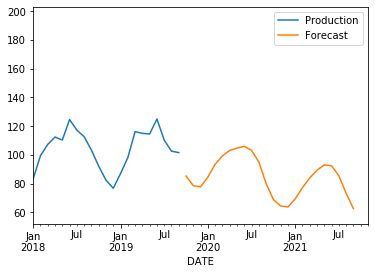

In [71]:
plt.figure(figsize=(12,8))
forecast_df.plot(ax=df.plot())
plt.xlim('2018-01-01','2021-11-01')

In [72]:
from sklearn.metrics import mean_squared_error

In [73]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

7.903810747123722